In [3]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns
# set the plotting style
sns.set_style("whitegrid")

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

In [4]:
df = pd.read_csv(
    '/Users/carterwebb/Desktop/5100_Foundation_Data/edu_5100_Webb/edu/data/education_clean.csv'
)

In [5]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,charter
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No


## Lets now look into the data with some exploratory analysis. 



Plotting the correleation information within this data will give us a look at what further analysis we will take. 

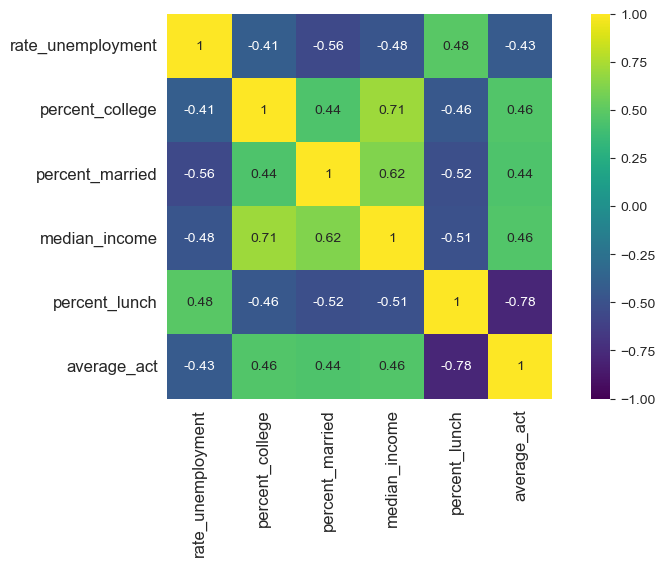

In [6]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state', 'charter']

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

Making pair plots is always another good introductory look into the data. 

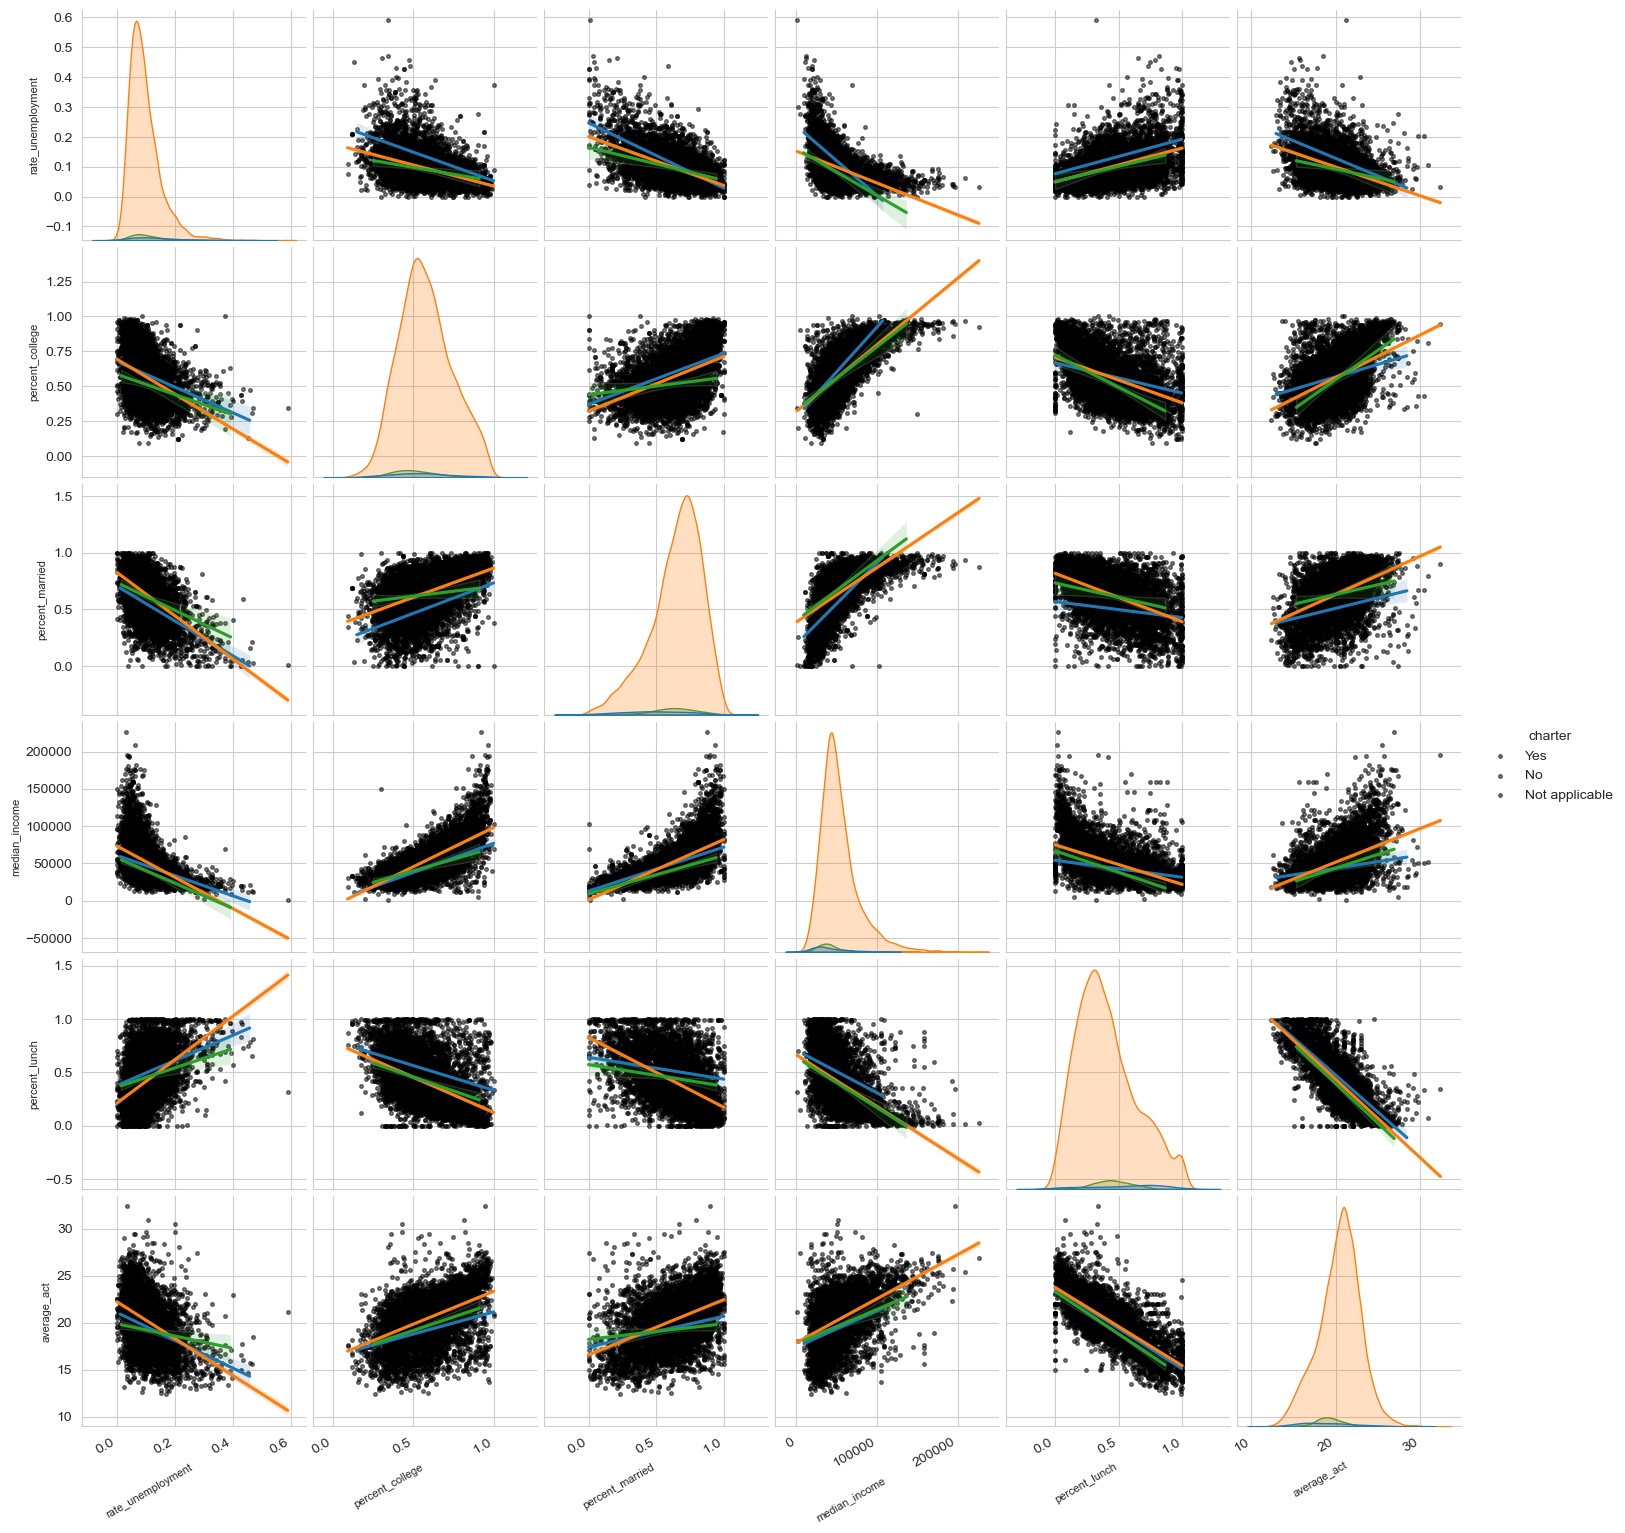

In [7]:
fig = sns.pairplot(
    data=df,
    vars=numerical_predictors + ['average_act'],
    hue='charter',
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')  # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

Box plots allow us to view the amount of outliers in each data set, however, we need to be careful and remove median income as it will shrink all other perdictors due to their scaling differences. We can plot this one seperately. 

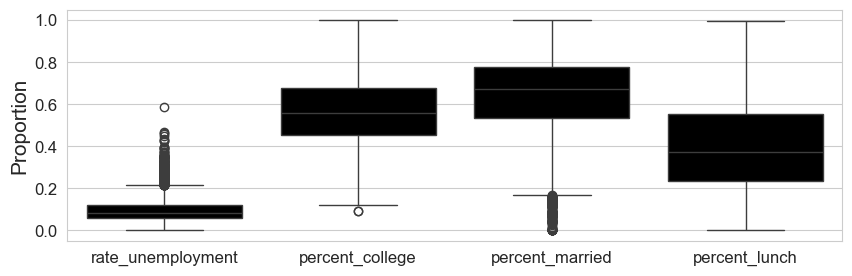

In [8]:
plt.figure(figsize=(10,3))

fractions = list(numerical_predictors)
fractions.remove('median_income')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

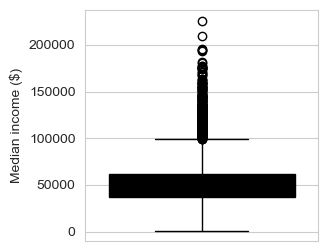

In [9]:
plt.figure(figsize=(3,3))

sns.boxplot(data=df, y='median_income', color='k')

plt.ylabel('Median income ($)')

plt.show()

# Summary: Taken from Course Notes

1.  The numerical predictors are related to `average_act`. The relationships appear roughly linear.

2.  The numerical predictors are correlated with each other, suggesting that not all predictors will be necessary.

3.  Some variables have skewed distributions, suggesting that transformations of input variables might be useful.

4. There are outliers in `rate_unemployment`, `percent_college`, `percent_married` and `median_income`. None of these are obviously incorrect values; they likely reflect skewed distributions. We may consider applying something like a log transformation to these predictors as we explore different models.

5. The relationships are similar across charter and non-charter schools, but might be significantly different.

# Lets now Begin Modeling

### Single input models. Median Income vs ACT

For each of our predictors we can fit and model using regression modeling, some may need polynomial regressions, but this will be on a case by case basis. 

#### Median income

Ploting a linear regression line and the scatter plot

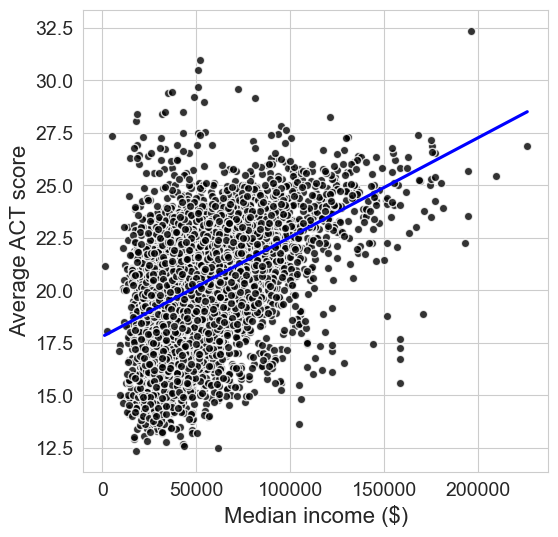

In [10]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Fitting the simple linear regression model, this entails proposing a relationship...

average_act_i = β₀ + β₁ * median_income_i + ε_i

### Then minimizing the sum squared redisuals to fit the data...

 minimize  Σ (average_act_i − (β₀ + β₁ * median_income_i))²

In [11]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=df).fit()

In [12]:
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1934.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:30:44   Log-Likelihood:                -16043.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.210e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8026      0.063    284.794

### In order to determine numerical assessment of fit accuracy, compute the R-squared and Root Mean Squared Error (RMSE)

	•	RMSE → penalizes large errors more (because of squaring)
	•	R² → measures proportion of variance explained, not error size

In [14]:
model_median_income.rsquared

np.float64(0.2111864897930108)

R² = 1 − [ Σ (y_i − ŷ_i)² / Σ (y_i − ȳ)² ]

Where: 

	•	Σ (y_i − ŷ_i)² = Residual Sum of Squares (RSS)
	•	Σ (y_i − ȳ)² = Total Sum of Squares (TSS)
	•	ȳ = mean of the observed values

Compute the RMSE

In [15]:
y_hat = model_median_income.predict()

In [16]:
np.sqrt(mean_squared_error(df['average_act'], y_hat)).round(3)

np.float64(2.228)

RMSE = sqrt( Σ (y_i − ŷ_i)² / n )

Where:

	•	y_i = actual (observed) value
	•	ŷ_i = predicted value
	•	n = number of observations


Compute the mean absolute error

In [17]:
mean_absolute_error(df['average_act'], y_hat)

1.712938698068855

MAE = Σ |y_i − ŷ_i| / n

Where:

	•	y_i = actual (observed) value
	•	ŷ_i = predicted value
	•	n = number of observations

Residual plot for graphical assessment of model fit

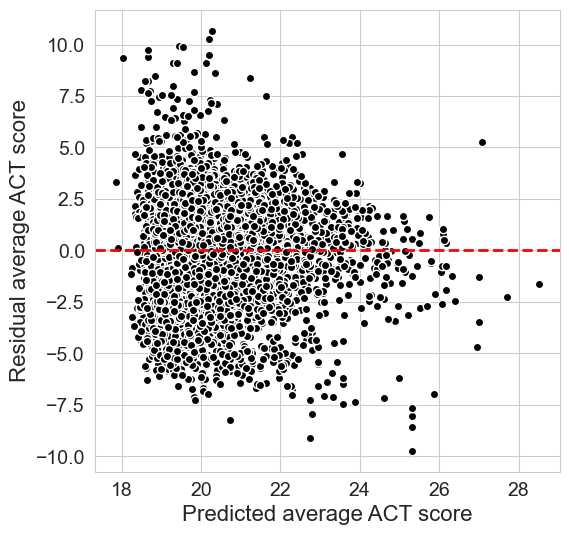

In [56]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Try a quadratic model.

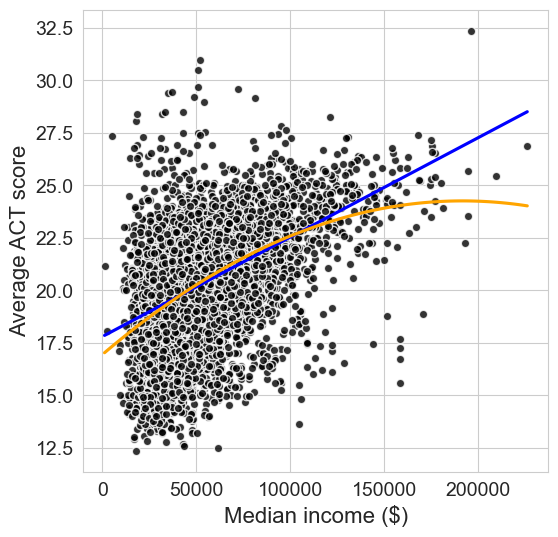

In [20]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            order=2, ## This is where you specify the quadratic model. 
            color='orange',
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

### Fit a quadratic linear regression model, process is similar as before, but adding I(median_income**2)

In [21]:
model_median_income2 = smf.ols(
    formula='average_act ~ median_income + I(median_income**2)',
    data=df).fit()

In [22]:
print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1013.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:49:18   Log-Likelihood:                -16007.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.94

##### Assess the model significance

In [23]:
model_median_income2.pvalues

Intercept                0.000000e+00
median_income            2.631899e-99
I(median_income ** 2)    1.395848e-17
dtype: float64

In [24]:
anova_lm(model_median_income, model_median_income2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7225.0,35865.012794,0.0,NaN,NaN,NaN
1,7224.0,35505.105960,1.0,359.906834,73.227974,1.395848e-17


Lets asses it variance and accuracy. 

## MAE

In [26]:
mean_absolute_error(df['average_act'], model_median_income2.predict())

1.6972389257635734

Comparing this to the linear model from before. 

In [27]:
mean_absolute_error(df['average_act'], model_median_income2.predict())

1.6972389257635734

In [28]:
mean_absolute_error(df['average_act'], model_median_income.predict())

1.712938698068855

# Unemployment rate

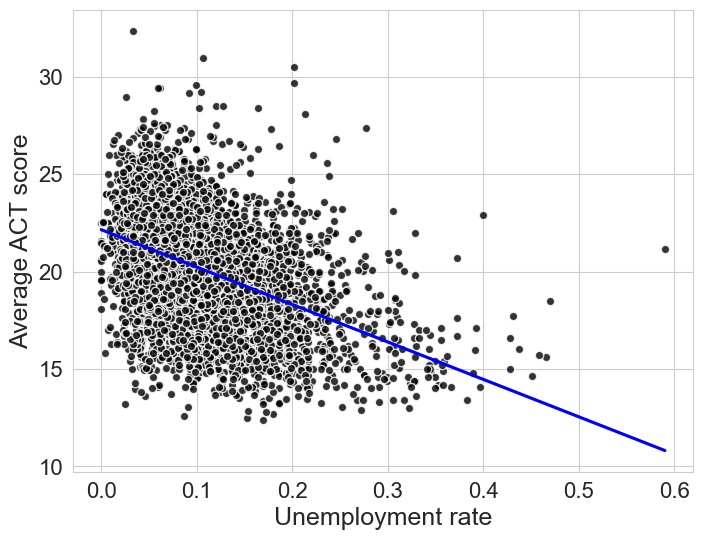

In [40]:
plt.figure(figsize=(8, 6))

sns.regplot(data=df,
            x='rate_unemployment',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
)

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16)

plt.show()

In [41]:
model_ru = smf.ols(formula='average_act ~ rate_unemployment', data=df).fit()

In [42]:
print(model_ru.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     1669.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:07:26   Log-Likelihood:                -16149.
No. Observations:                7227   AIC:                         3.230e+04
Df Residuals:                    7225   BIC:                         3.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1512      0.05

The R^2 = 0.19, which is low and may imply we need to approach differently.

Make a residual plot to assess the model.

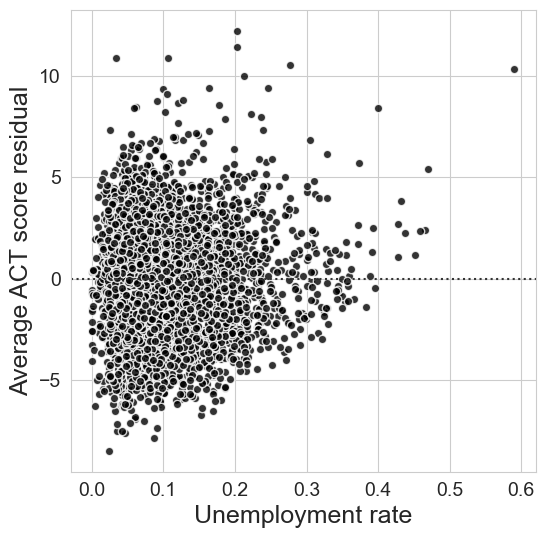

In [43]:
plt.figure(figsize=(6,6))

sns.residplot(data=df,
              x = 'rate_unemployment',
              y = 'average_act',
              scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score residual', fontsize = 18)

plt.tick_params(labelsize=14)

plt.show()

Is a quadratic model is better?

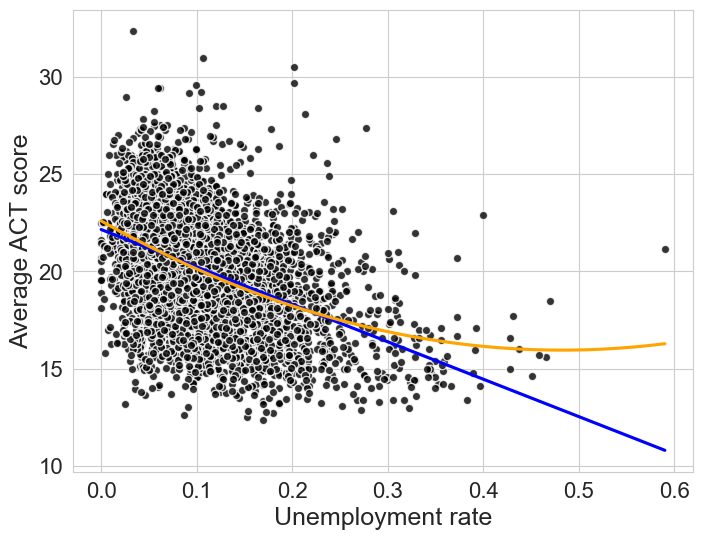

In [44]:
plt.figure(figsize=(8,6))

sns.regplot(x='rate_unemployment',
            y='average_act',
            color='blue',
            data=df,
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(x='rate_unemployment',
            y='average_act',
            color='orange',
            order = 2,
            data=df,
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16)

plt.show()

In [45]:
model_ru2 = smf.ols(formula='average_act ~ rate_unemployment + I(rate_unemployment**2)', data=df).fit()

In [46]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,charter
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No


In [47]:
print(model_ru2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     865.0
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:07:30   Log-Likelihood:                -16125.
No. Observations:                7227   AIC:                         3.226e+04
Df Residuals:                    7224   BIC:                         3.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### Not much better.

In [48]:
anova_lm(model_ru, model_ru2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7225.0,36932.894308,0.0,NaN,NaN,NaN
1,7224.0,36682.406013,1.0,250.488295,49.329574,2.360918e-12


## Percent of adults with a college degree

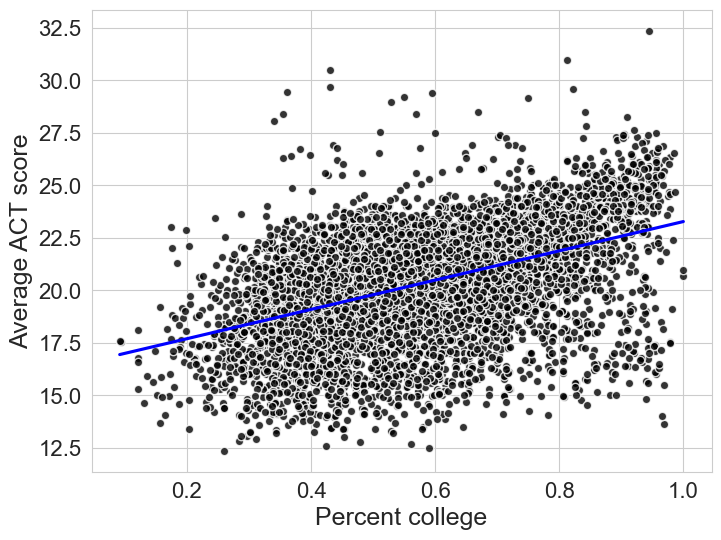

In [60]:
plt.figure(figsize=(8,6))

sns.regplot(data=df,
            x='percent_college',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent college', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

In [ ]:
model_pc = smf.ols(formula='average_act ~ percent_college', data=df).fit()

In [ ]:
print(model_pc.summary())

Again another low correlation. The R^2 = 0.20.

#### Percent of adults married

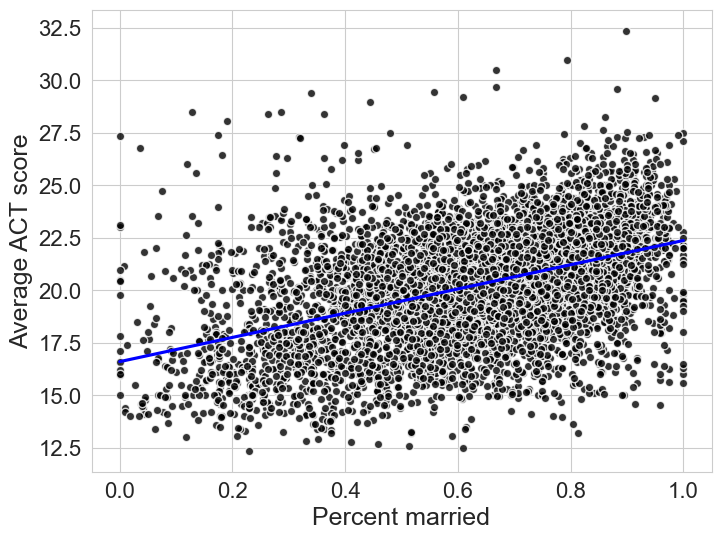

In [49]:
plt.figure(figsize=(8,6))


sns.regplot(data=df,
            x='percent_married',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent married', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

In [50]:
model_pm = smf.ols(formula='average_act ~ percent_married', data=df).fit()

In [51]:
print(model_pm.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1733.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:08:27   Log-Likelihood:                -16124.
No. Observations:                7227   AIC:                         3.225e+04
Df Residuals:                    7225   BIC:                         3.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.6046      0.093    1

The R^2 = 0.20.

#### Percent of students with free or reduced price lunch

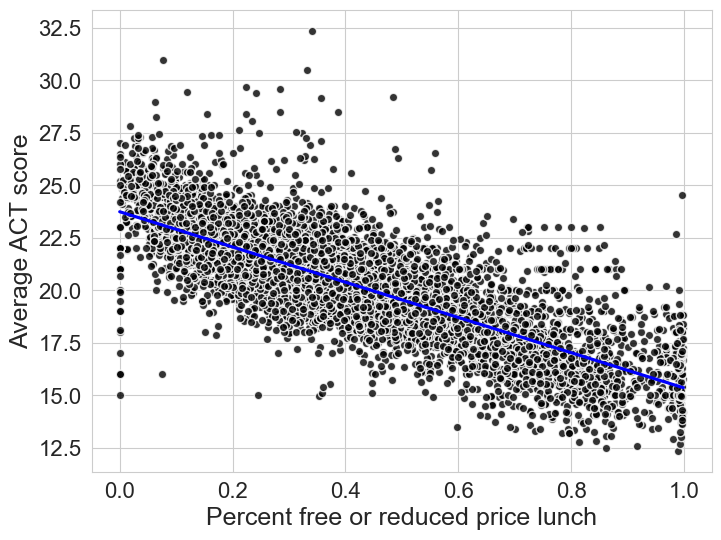

In [52]:
plt.figure(figsize=(8,6))

sns.regplot(data=df,
            x='percent_lunch',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Percent free or reduced price lunch', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)


# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 16);

In [53]:
model_pl = smf.ols(formula='average_act ~ percent_lunch', data=df).fit()

print(model_pl.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.149e+04
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:09:14   Log-Likelihood:                -13461.
No. Observations:                7227   AIC:                         2.693e+04
Df Residuals:                    7225   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7429      0.037    641.745

Here we see a strong negative correlation, R^2 = 0.61, between reduced price lunch and the average ACT score 

# Multiple linear regression

Since we saw many of these predictors were adequate for linear regression lets simplify this process to do it with all socioeconomic variables as predictors.

In [54]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch',
    data=df).fit()

In [55]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2438.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:14:43   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.667e+04
Df Residuals:                    7221   BIC:                         2.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6972      0.13

### Residual Plot

In [57]:
y_hat = model.predict()

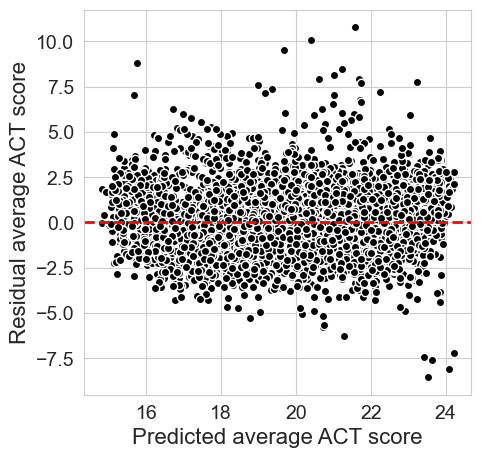

In [58]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### MAE

In [59]:
mean_absolute_error(df['average_act'], model.predict())

1.1453304788884031

## Summary: Taken from coursework

1. The multiple linear regression model with all socioeconomic predictors can predict ACT scores with an average error of roughly 1 point using these predictors.

2. The residual plot suggests that there will be limited improvement from adding transformations of these predictors.

3. Not all predictors have significant coefficients.

4. Adding predictors to the model may improve the performance.

# Fit a reduced model with the significant predictors

Now we know from our work above, the we can make a subset of statistically significant predictors to enhance and simplify our modeling techniques.

In [61]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch',
    data=df).fit()

In [62]:
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:21:03   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6400      0.10

## Residual Plots

In [63]:
y_hat = model_reduced.predict()

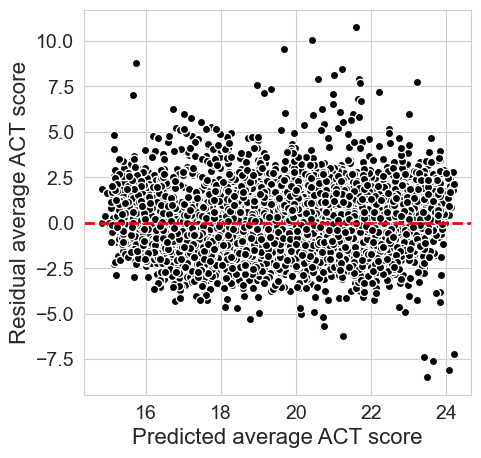

In [64]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

## MAE

In [65]:
mean_absolute_error(df['average_act'], model_reduced.predict())

1.1454832950346379

### Compare the full and reduced models

In [66]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
full model,1.1453,0.6280
reduced model,1.1455,0.6279


##### Use an ANOVA to test the significance of difference between models

In [67]:
anova_lm(model_reduced, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7223.0,16916.619167,0.0,NaN,NaN,NaN
1,7221.0,16915.612457,2.0,1.006711,0.214874,0.806648


## Summary: Taken From Coursework

1. The model predicting the average ACT score from `rate_unemployment`, `percent_college` and, `percent_lunch` is not significantly different than the model with all five socioeconomic variables as predictors.

2. Adding predictors to the model may improve the performance.

3. We have not yet determined the relative importance of each predictor in the model.

## Scaling

##### Scale the predictor variables in the reduced model to have mean 0 and standard deviation 1 and add them to the data frame

In [68]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_lunch']

In [69]:
scaled_columns = [var + '_normalized' for var in predictor_variables]

print(scaled_columns)

['rate_unemployment_normalized', 'percent_college_normalized', 'percent_lunch_normalized']


The next step determines what transformation must be taken in order to fit these variables with a mean of 0 and sd of 1.

In [70]:
scaler = StandardScaler().fit(df[predictor_variables])

In [71]:
df[scaled_columns] = scaler.transform(df[predictor_variables])

In [72]:
df

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,charter,rate_unemployment_normalized,percent_college_normalized,percent_lunch_normalized
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes,0.380125,-0.774475,-1.466983
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No,-0.573936,0.544280,-1.272689
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No,-0.706931,0.781372,-1.339271
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No,-0.914109,0.721933,-0.484817
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No,-0.343648,0.406606,-0.631332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,560530200294,0.034549,0.590780,0.720077,64891.0,18.500000,0.232156,2016-2017,WY,82901,Regular School,High,No,-1.094210,0.107781,-0.761480
7223,560569000311,0.069538,0.633860,0.808841,44603.0,22.300000,0.083871,2016-2017,WY,82833,Regular School,High,No,-0.475779,0.369009,-1.394537
7224,560569500360,0.035159,0.764566,0.776570,44896.0,21.500000,0.184829,2016-2017,WY,82801,Regular School,High,No,-1.083436,1.161579,-0.963527
7225,560576200324,0.063877,0.670532,0.879324,92134.0,19.700000,0.112583,2016-2017,WY,82935,Regular School,High,No,-0.575842,0.591382,-1.271960


##### Check the mean and standard deviation of the transformed data.

In [ ]:
df[scaled_columns].agg(['mean', 'std']).round(3)

,rate_unemployment_normalized,percent_college_normalized,percent_lunch_normalized
mean,-0.0,-0.0,0.0
std,1.0,1.0,1.0


Now we fit the multiple linear regression model using our newly normalized predictors

In [73]:
model_normalized = smf.ols(
    formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized',
    data=df).fit()

In [74]:
print(model_normalized.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:40:48   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Note: The precent lunch variable has a much larger increase in ACT value per unit increase in lunches. This points towards it being the strongest predictor. 

### Accuracy Check 

In [75]:
mae_normalized = mean_absolute_error(df['average_act'], model_normalized.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_normalized = model_normalized.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_normalized, mae_reduced],
              'R-squared': [r2_normalized, r2_reduced]},
              index=['normalized model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
normalized model,1.1455,0.6279
reduced model,1.1455,0.6279


## Summary

1. The percent of students at a school receiving free or reduced price lunch was the strongest predictor in this analysis.
2. While all numerical measures are the same in the scaled analysis, it still provides meaningful information. This is because it does not change the overall linear regression relationship, however, it changes what the units are, thus showing variables that carry weight.  

## Conclusion: Taken from Coursework

The analysis shows that college entrance test scores (ACT and SAT) are related to socioeconomic variables.

In particular, using only the percent of students at a school receiving free or reduced price lunch, we can predict ACT scores to within a single point, on average.

The percent of students at a school receiving free or reduced price lunch was the strongest predictor in this analysis. It was also the only variable measured for students at the school, rather than for the neighborhood. It is an open question how important the other predictors would be if they were measured for the students at the school, rather than for the neighborhood.

